<a href="https://colab.research.google.com/github/arkadijshmelev/predict_yandex_stock_quotes/blob/master/predict_yandex_stock_quotes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Библиотеки

In [7]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.api import SimpleExpSmoothing
from sklearn.linear_model import LinearRegression
from prophet import Prophet
import pmdarima as pm
from sklearn import neighbors
from sklearn import ensemble
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn import metrics
from warnings import filterwarnings
filterwarnings('ignore')
%matplotlib inline

## Данные

In [9]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [10]:
# Загрузим данные с google drive.
data = drive.CreateFile({'id': '144MwDreXGFqY18cAIqDRDFYFW8neZViR'})
data.GetContentFile('yandex_stock_quotes.csv')

In [11]:
# Загружаем данные.
df = pd.read_csv('yandex_stock_quotes.csv')
df = df.drop('Unnamed: 0', axis=1)
# Выведем для просмотра.
display(df.head())

,date,open,high,low,close,volume
0,2014-06-04,1546.7,1546.8,1163.0,1170.0,35146.0
1,2014-06-05,1187.3,1195.0,1141.1,1145.1,24974.0
2,2014-06-06,1158.3,1173.5,1151.0,1163.0,7889.0
3,2014-06-09,1178.9,1185.6,1155.7,1172.1,7304.0
4,2014-06-10,1178.9,1181.0,1160.1,1170.0,3216.0


В данных есть несколько переменных - date, open, high, low, close, volume.

Признаки «open» и «close» представляют собой начальную и конечную цену, по которой акция торгуется в определенный день.

High, low - это максимальная и минимальная цена акции за день.

Volume - суммарный объем купленных и проданных акций на текущий момент за период с начала торгового дня.

Еще одной важной вещью является то, что рынок закрыт по выходным и праздничным дням. А значит данные по котировкам в эти даты отсутствуют.

Расчет прибыли или убытка обычно определяется ценой закрытия акции в течение дня, поэтому цену закрытия примем в качестве целевой переменной.

In [12]:
# Переводим дату в формат datetime.
df['date'] = pd.to_datetime(df['date'])
# Делаем признак даты индексом.
df = df.set_index('date')

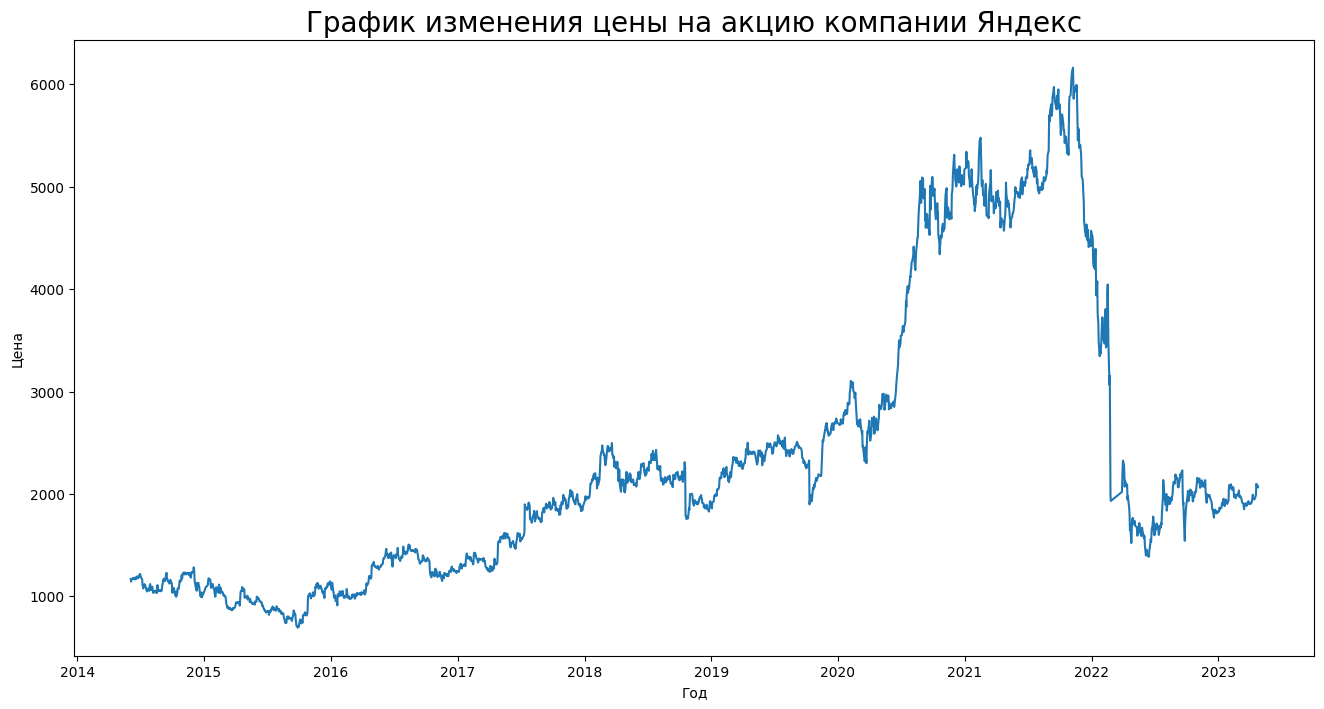

In [13]:
# Задаем размер фигуры.
plt.figure(figsize=(16, 8))

# Строим график.
plt.plot(df['close'])
plt.title('График изменения цены на акцию компании Яндекс', size=20)
plt.ylabel('Цена')
plt.xlabel('Год');

На графике видно, что в конце 2015 года начался восходящий тренд, который продолжался конца 2022 года. Далее наблюдается резкое падение. Скорее всего из-за начала спецоперации в Украине.

In [14]:
# Оставим только признак цены закрытия.
df_for_ses = df[['close']]
# Выведем для просмотра.
display(df_for_ses.head())

,close
date,
2014-06-04,1170.0
2014-06-05,1145.1
2014-06-06,1163.0
2014-06-09,1172.1
2014-06-10,1170.0


In [15]:
# Выведем статистику.
display(df_for_ses.describe())

,close
count,2222.000000
mean,2326.356841
std,1360.917775
min,694.000000
25%,1286.125000
50%,1968.600000
75%,2567.850000
max,6161.000000


Видно, что средняя цена акции за все время - 2326 рублей, максимальное значени - 6161 рубль, минимальное - 694 рубля.

In [16]:
# Разделим данные на тренировочную и тестовую выборки.
train = df_for_ses[:'2021-03-01']
test = df_for_ses['2021-03-01':]
print('Размер тренировочной выборки: \n', train.shape)
print('Размер тестовой выборки: \n', test.shape)

Размер тренировочной выборки: 
 (1697, 1)
Размер тестовой выборки: 
 (526, 1)


## Экспоненциальное сглаживание - SES

In [17]:
# Иницианализируем модель экспоненциального сглаживания.
ses = SimpleExpSmoothing(train)
# Задаем коэффициент сглаживания.
alpha = 0.7
# Обучаем модель.
model = ses.fit(smoothing_level = alpha, optimized = False)
# Делаем предсказание.
forecast = model.forecast(526)
# Выводим предсказание для просмотра.
print(forecast)

1697    4953.314938
1698    4953.314938
1699    4953.314938
1700    4953.314938
1701    4953.314938
           ...     
2218    4953.314938
2219    4953.314938
2220    4953.314938
2221    4953.314938
2222    4953.314938
Length: 526, dtype: float64


In [18]:
# Добавляем предсказание в тестовую выборку.
test_ses = test.copy()
test_ses['prediction'] = forecast.iloc[0]

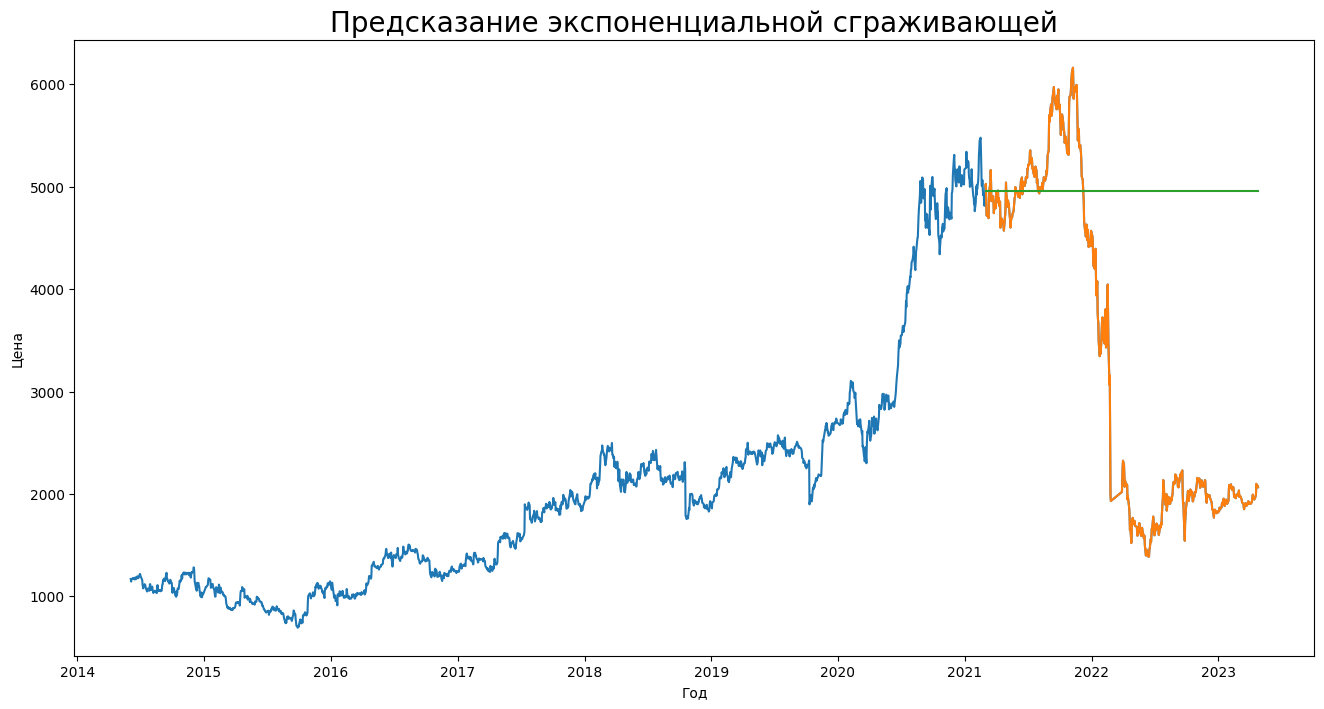

In [19]:
# Задаем размер фигуры.
plt.figure(figsize=(16, 8))

# Построим график.
plt.plot(df['close'])
plt.plot(test_ses[['close', 'prediction']])
plt.title('Предсказание экспоненциальной сграживающей', size=20)
plt.ylabel('Цена')
plt.xlabel('Год');

На графике очень хорошо видно, что экспоненциальное сглаживание не имеет никакой предсказательной способности.

In [20]:
# Выведем метрики.
print('MAE: {:.3f}'.format(metrics.mean_absolute_error(test, forecast)))
print()
print('RMSE: {:.3f}'.format(metrics.mean_squared_error(test, forecast)))

MAE: 1815.778

RMSE: 5064681.484


По метрике RMSE видно, что модель совершенно не уловила зависимостей и делает предсказание далекое от действительности.

## Линейная регрессия - LinearRegression

### Без добавления новых признаков

In [21]:
# Делаем копию.
df_for_lr1 = df_for_ses.copy()

In [22]:
# Разделим данные на тренировочные и тестовые выборки.
X_train = pd.DataFrame(range(df_for_lr1['close'].shape[0]))[
    : train.shape[0]
]
X_test = pd.DataFrame(range(df_for_lr1['close'].shape[0]))[
    train.shape[0] - 1 :
]
y_train = train['close']
y_test = test['close']

In [23]:
# Иницианализируем модель линейной регрессии.
lr = LinearRegression()
# Обучаем модель.
lr.fit(X_train, y_train)
# Делаем предсказание.
lr_predict = lr.predict(X_test)

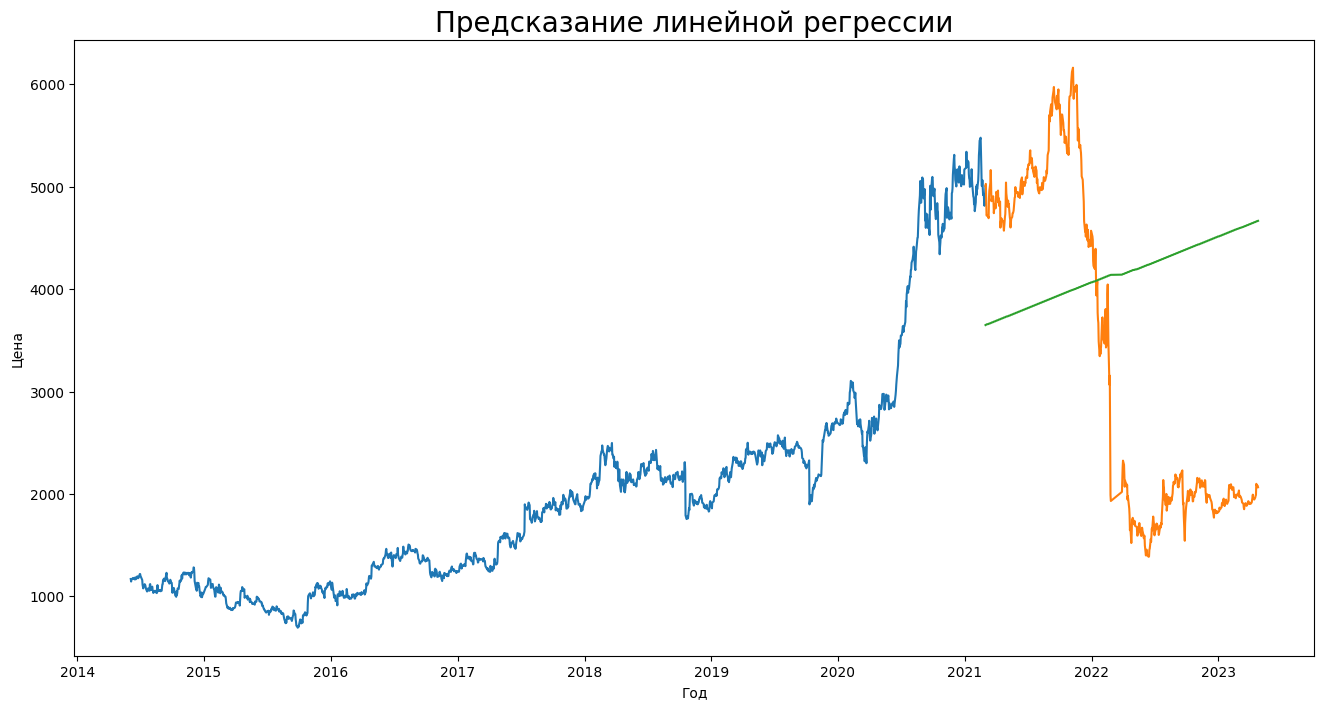

In [24]:
# Задаем размер фигуры.
plt.figure(figsize=(16, 8))

# Построим график.
plt.plot(y_train)
plt.plot(y_test)
plt.plot(pd.Series(lr_predict, index=y_test.index))
plt.title('Предсказание линейной регрессии', size=20)
plt.ylabel('Цена')
plt.xlabel('Год');

На графике линейная регрессия без добавления признаков показывает не очень хороший результат. Сначала модель уловила тренд, а потом пропустила падение.

In [25]:
# Выведем метрики.
print('MAE: {:.3f}'.format(metrics.mean_absolute_error(y_test, lr_predict)))
print()
print('RMSE: {:.3f}'.format(metrics.mean_squared_error(y_test, lr_predict)))

MAE: 1866.739

RMSE: 4047105.533


Метрики показывают плохой результат. Значит закономерность линейная модель не уловила.

### С добавлением новых признаков

In [26]:
# Делаем копию.
df_for_lr2 = df.copy()
# Добавляем в данные скользящие средние.
df_for_lr2['SMA_200'] = df_for_lr2.close.shift().rolling(window=200).mean()
df_for_lr2['SMA_300'] = df_for_lr2.close.shift().rolling(window=300).mean()
# Добавим волатильность.
df_for_lr2['volatility'] = df_for_lr2.close.shift().pct_change(1).mul(100).abs()
# Добавляем дни недели.
df_for_lr2['weekday'] = df_for_lr2.index.weekday
# Удалим пропуски.
df_for_lr2 = df_for_lr2.dropna()
# Формируем новый датафрейм.
df_for_lr2 = df_for_lr2[['close', 'volume', 'SMA_200', 'SMA_300', 'volatility', 'weekday']]
# Выведем для просмотра.
display(df_for_lr2.head())

,close,volume,SMA_200,SMA_300,volatility,weekday
date,,,,,,
2015-08-17,835.0,64859.0,1007.350,1042.005667,0.953516,0
2015-08-18,819.0,43912.0,1005.815,1040.889000,0.481348,1
2015-08-19,799.0,125770.0,1004.145,1039.802000,1.916168,2
2015-08-20,780.0,76956.0,1002.160,1038.588667,2.442002,3
2015-08-21,770.0,60797.0,1000.020,1037.281667,2.377972,4


In [27]:
# Разделим данные на тренировочные и тестовые выборки.
train = df_for_lr2.drop('close', axis=1)
test = df_for_lr2['close']
X_train = train[:'2021-03-01']
X_test = train['2021-03-01':]
y_train = test[:'2021-03-01']
y_test = test['2021-03-01':]
# Проверим размерности.
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)

X_train:  (1397, 5)
y_train:  (1397,)
X_test:  (526, 5)
y_test:  (526,)


In [28]:
# Иницианализируем модель линейной регрессии.
model_lr = LinearRegression()
# Обучим модель.
model_lr.fit(X_train, y_train)
# Сделаем предсказание на тестовой выборке.
pred_test_model_lr = model_lr.predict(X_test)
# Вывеедм метрику.
print('MAE: {:.3f}'.format(metrics.mean_absolute_error(y_test, pred_test_model_lr)))
print()
print('RMSE: {:.3f}'.format(metrics.mean_squared_error(y_test, pred_test_model_lr)))

MAE: 1162.381

RMSE: 2315472.988


Метрика заметно улучшилась, значит добавление новых признаков в модель дало результат.

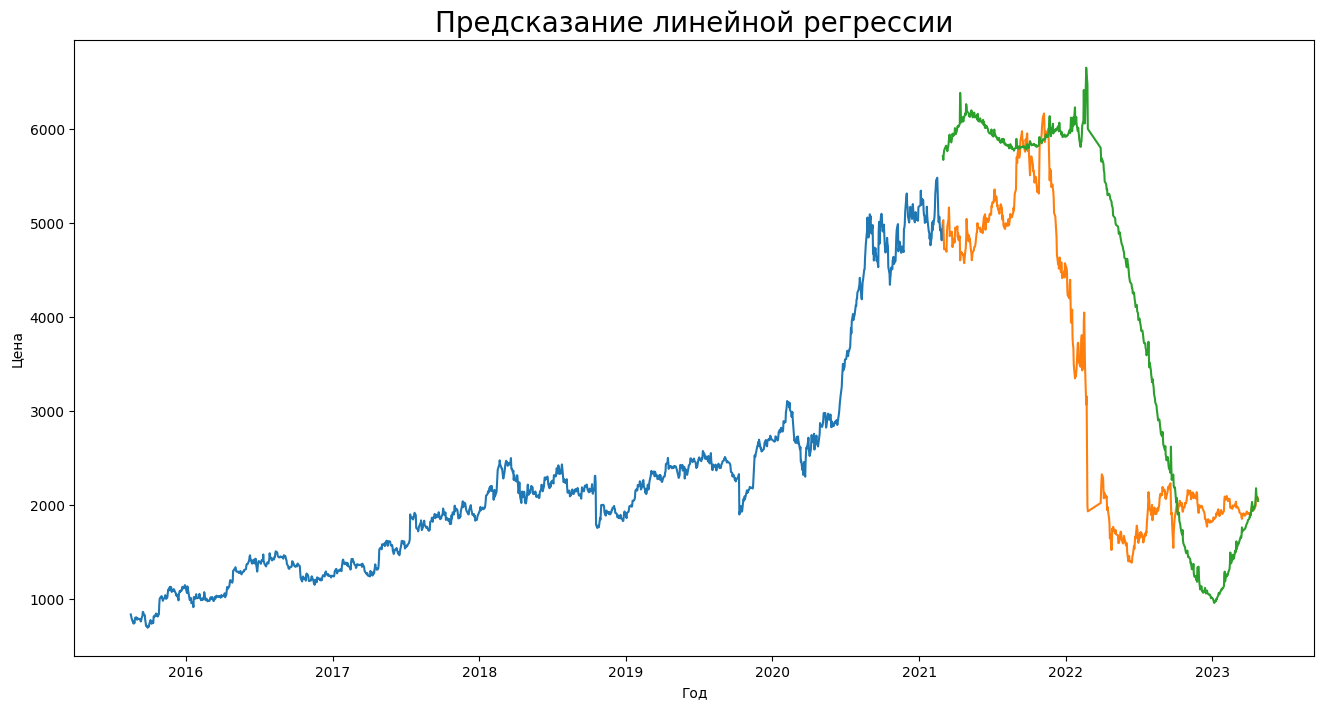

In [29]:
# Задаем размер фигуры.
plt.figure(figsize=(16, 8))

# Построим график.
plt.plot(y_train)
plt.plot(y_test)
plt.plot(pd.Series(pred_test_model_lr, index=y_test.index))
plt.title('Предсказание линейной регрессии', size=20)
plt.ylabel('Цена')
plt.xlabel('Год');

По графику видно, что модель улавливает колебания цен, но со значительным отставанием.

### Нормализация данных - MinMaxScaler

In [30]:
# Нормализуем тренировочные и тестовые выборки с помощью метода MinMaxScaler.
# Создаем объект класса MinMaxScaler.
scaler = preprocessing.MinMaxScaler()
# Обучаем модель на тренировочной выборке.
scaler.fit(X_train)
# Производим стандартизацию тренировочной выборки.
X_train_scaled = scaler.transform(X_train)
# Производим стандартизацию тестовой выборки.
X_test_scaled = scaler.transform(X_test)

In [31]:
# Иницианализируем модель линейной регрессии.
model_lr1 = LinearRegression()
# Обучим модель.
model_lr1.fit(X_train_scaled, y_train)
# Сделаем предсказание на тестовой выборке.
pred_test_model_lr_scaled = model_lr1.predict(X_test_scaled)
# Вывеедм метрику.
print('MAE: {:.3f}'.format(metrics.mean_absolute_error(y_test, pred_test_model_lr_scaled)))
print()
print('RMSE: {:.3f}'.format(metrics.mean_squared_error(y_test, pred_test_model_lr_scaled)))

MAE: 1162.381

RMSE: 2315472.988


После нормализации данных метрика не изменилась. Можно сделать вывод, что нет необходимости в нормализации при использовании линейной регрессии для предсказания цен на акции.

## Регрессия на основе k ближайших соседей - KNeighborsRegressor

In [32]:
# Иницианализируем модель на основе ближайших соседей.
model_knn = neighbors.KNeighborsRegressor()
# Обучаем модель.
model_knn.fit(X_train, y_train)
# Делаем предсказание на тестовой выборке.
pred_test_knn = model_knn.predict(X_test)
# Вывеедм метрику.
print('MAE: {:.3f}'.format(metrics.mean_absolute_error(y_test, pred_test_knn)))
print()
print('RMSE: {:.3f}'.format(metrics.mean_squared_error(y_test, pred_test_knn)))

MAE: 1341.665

RMSE: 2499521.403


Метрика после применения регрессии на основе k ближайших соседей опять ухудшилась.

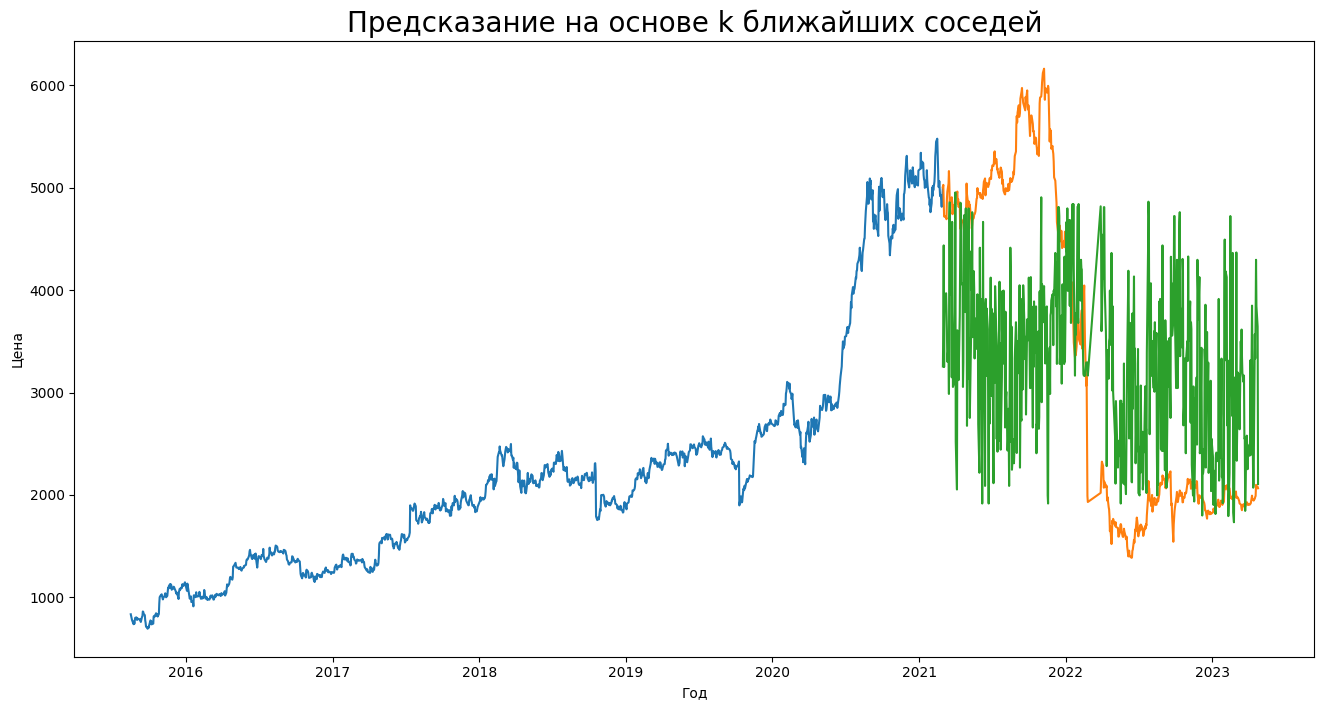

In [33]:
# Задаем размер фигуры.
plt.figure(figsize=(16, 8))

# Построим график.
plt.plot(y_train)
plt.plot(y_test)
plt.plot(pd.Series(pred_test_knn, index=y_test.index))
plt.title('Предсказание на основе k ближайших соседей', size=20)
plt.ylabel('Цена')
plt.xlabel('Год');

На графике видно, что модель не улавливает закономерностей и не предсказывает цену.

### Нормализация данных - MinMaxScaler

In [34]:
# Иницианализируем модель на основе ближайших соседей.
model_knn1 = neighbors.KNeighborsRegressor()
# Обучаем модель.
model_knn1.fit(X_train_scaled, y_train)
# Делаем предсказание на тестовой выборке.
pred_test_knn1 = model_knn1.predict(X_test_scaled)
# Выводим метрику.
print('MAE: {:.3f}'.format(metrics.mean_absolute_error(y_test, pred_test_knn1)))
print()
print('RMSE: {:.3f}'.format(metrics.mean_squared_error(y_test, pred_test_knn1)))

MAE: 1311.312

RMSE: 3220561.683


После применения нормализации метрика немного стала лучше, но в целом результат очень плохой.

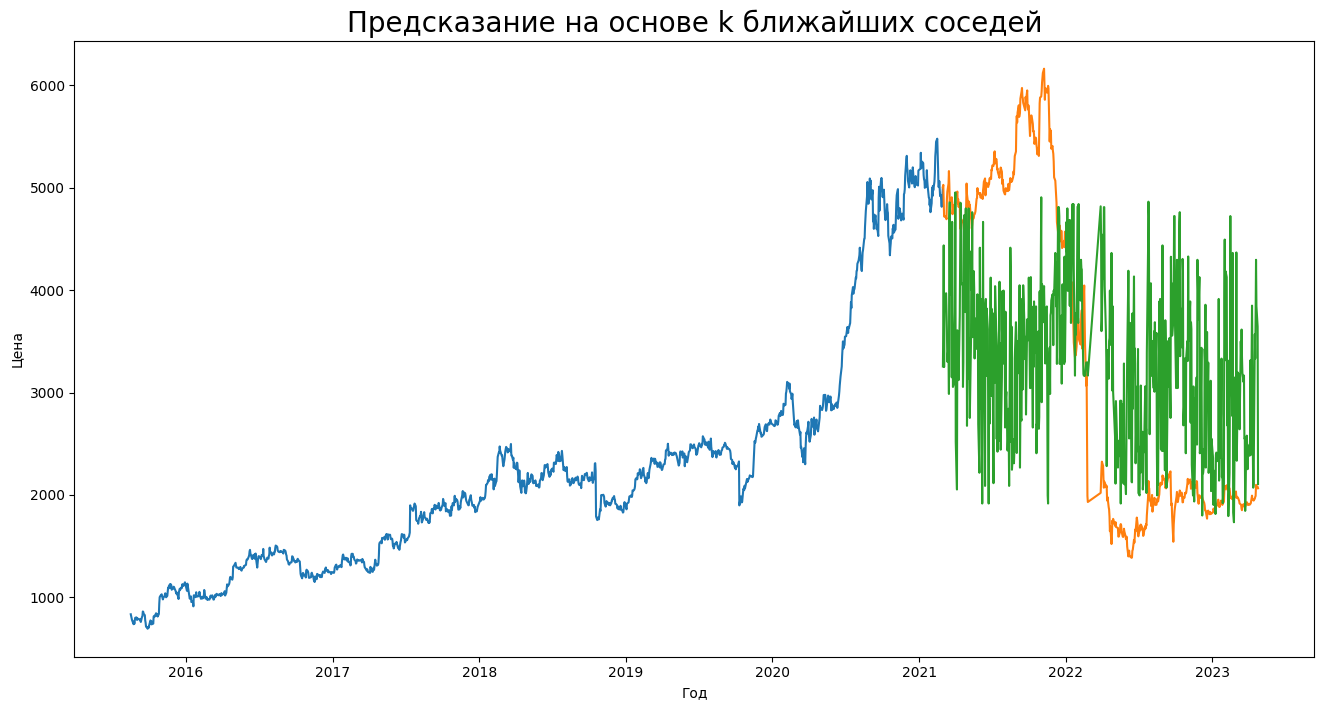

In [35]:
# Задаем размер фигуры.
plt.figure(figsize=(16, 8))

# Построим график.
plt.plot(y_train)
plt.plot(y_test)
plt.plot(pd.Series(pred_test_knn, index=y_test.index))
plt.title('Предсказание на основе k ближайших соседей', size=20)
plt.ylabel('Цена')
plt.xlabel('Год');

По графику видно, что модель не имеет предсказательной способности.

## Градиентный бустинг - GradientBoostingRegressor

### Поиск оптимальных гиперпараметров - GridSearchCV

In [36]:
# Иницианализируем модель градиентного бустинга.
model_gbr = ensemble.GradientBoostingRegressor()

# Задем сетку параметров для GridSearchCV.
grid = dict()
grid['n_estimators'] = [10, 50, 100, 500]
grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
grid['subsample'] = [0.5, 0.7, 1.0]
grid['max_depth'] = [3, 7, 9]
# Определяем процедуру оценки.
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# Иницианализируем модель GridSearchCV.
grid_search = GridSearchCV(estimator=model_gbr, param_grid=grid, n_jobs=-1, cv=cv)

# Обучаем модель.
%time grid_search.fit(X_train, y_train)
# Делаем предсказание.
pred_test_model_gbr = grid_search.predict(X_test)
# Выводим метрику.
print('MAE: {:.3f}'.format(metrics.mean_absolute_error(y_test, pred_test_model_gbr)))
print()
print('RMSE: {:.3f}'.format(metrics.mean_squared_error(y_test, pred_test_model_gbr)))
# Выводим необходимые параметры.
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

CPU times: user 21.7 s, sys: 1.87 s, total: 23.6 s
Wall time: 37min 46s
MAE: 1289.106

RMSE: 2987407.353
Наилучшие значения гиперпараметров: {'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 500, 'subsample': 0.7}


### Результаты поиска гиперпараметров

CPU times: total: 13.3 s

Wall time: 20min 26s

MAE: 1526.100

RMSE: 3205653.740

Наилучшие значения гиперпараметров: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 500, 'subsample': 0.7}

In [37]:
# Создаем объект класса градиетный бустинг с наилучшими подобранными параметрами.
gbr = ensemble.GradientBoostingRegressor(
	max_depth=9, # максимальная глубина дерева
    n_estimators=500, # количество деревьев
    random_state=42, # генератор случайных чисел
    learning_rate=0.1, # скорость обучения
    subsample=0.7 # доля выборок
)
# Обучаем модель на тренировочной выборке.
gbr.fit(X_train, y_train)
# Делаем предсказание на тестовой выборке.
pred_test_gbr = gbr.predict(X_test)
# Выводим метрику.
print('MAE: {:.3f}'.format(metrics.mean_absolute_error(y_test, pred_test_gbr)))
print()
print('RMSE: {:.3f}'.format(metrics.mean_squared_error(y_test, pred_test_gbr)))

MAE: 1351.843

RMSE: 3177363.598


Метрика стала еще хуже.

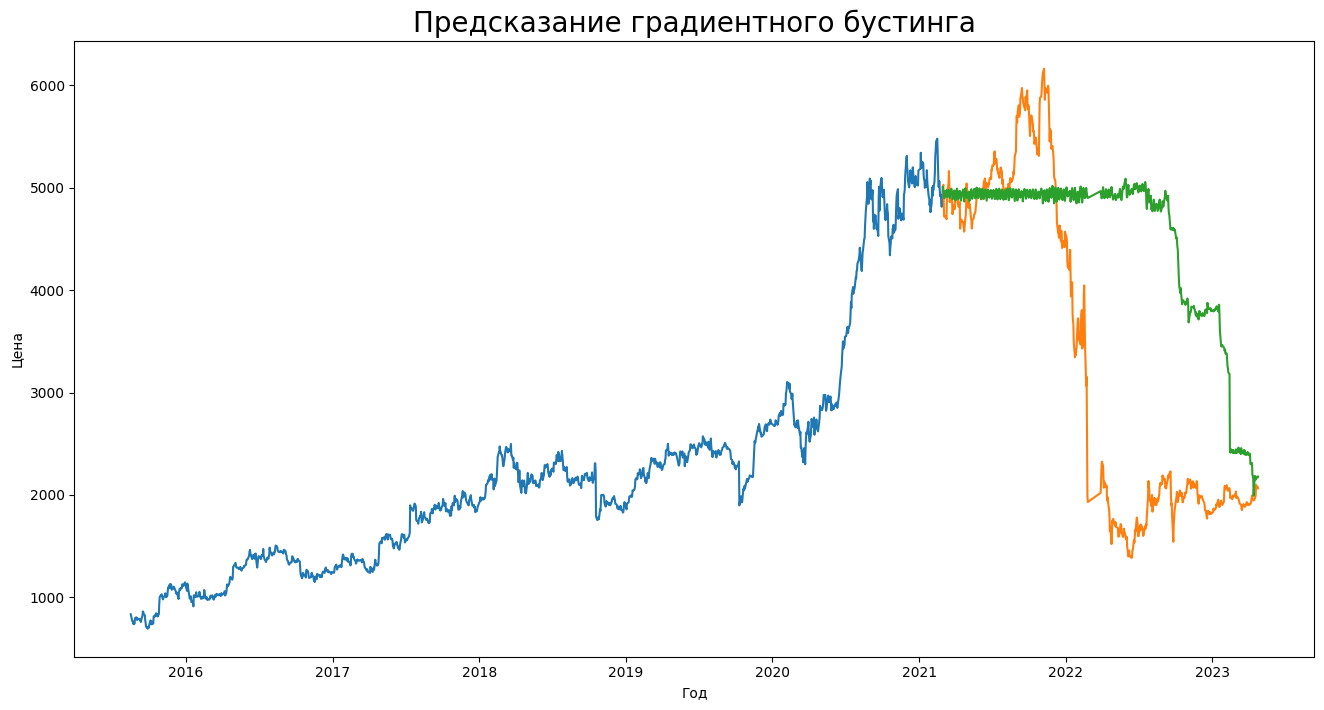

In [38]:
# Задаем размер фигуры.
plt.figure(figsize=(16, 8))

# Построим график.
plt.plot(y_train)
plt.plot(y_test)
plt.plot(pd.Series(pred_test_gbr, index=y_test.index))
plt.title('Предсказание градиентного бустинга', size=20)
plt.ylabel('Цена')
plt.xlabel('Год');

На графике видно, что модель не предсказывает поведение цены.

## Автоматическое обнаружение оптимальных параметров для модели ARIMA - AUTO ARIMA

In [39]:
df_for_aa = df_for_ses.copy()
# Разделим данные на тренировочную и тестовую выборки.
train = df_for_aa[:'2021-03-01']
test = df_for_aa['2021-03-01':]
# Выведем размеры выборок.
print('Размер тренировочной выборки: \n', train.shape)
print('Размер тестовой выборки: \n', test.shape)

Размер тренировочной выборки: 
 (1697, 1)
Размер тестовой выборки: 
 (526, 1)


In [40]:
model_aa = pm.auto_arima(
    train,
    start_p=1,
    d=1,
    start_q=1,
    max_p=3,
    max_q=3,
    D=1,
    start_P=0,
    m=5,
    test='adf',
    error_action='ignore',
    trace=True,
    suppress_warnings=True
)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[5]             : AIC=inf, Time=1.37 sec
 ARIMA(0,1,0)(0,1,0)[5]             : AIC=19120.934, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[5]             : AIC=18678.509, Time=0.49 sec
 ARIMA(0,1,1)(0,1,1)[5]             : AIC=inf, Time=1.22 sec
 ARIMA(1,1,0)(0,1,0)[5]             : AIC=19122.892, Time=0.10 sec
 ARIMA(1,1,0)(2,1,0)[5]             : AIC=18476.309, Time=1.73 sec
 ARIMA(1,1,0)(2,1,1)[5]             : AIC=inf, Time=3.65 sec
 ARIMA(1,1,0)(1,1,1)[5]             : AIC=inf, Time=1.21 sec
 ARIMA(0,1,0)(2,1,0)[5]             : AIC=18474.533, Time=0.52 sec
 ARIMA(0,1,0)(1,1,0)[5]             : AIC=18676.734, Time=0.29 sec
 ARIMA(0,1,0)(2,1,1)[5]             : AIC=inf, Time=1.86 sec
 ARIMA(0,1,0)(1,1,1)[5]             : AIC=inf, Time=1.13 sec
 ARIMA(0,1,1)(2,1,0)[5]             : AIC=18476.304, Time=0.76 sec
 ARIMA(1,1,1)(2,1,0)[5]             : AIC=inf, Time=3.08 sec
 ARIMA(0,1,0)(2,1,0)[5] intercept   : AIC=18476.527, Time=2.3

In [41]:
# Обучим модель.
model_aa.fit(train)
# Делаем предсказание.
forecast_aa = model_aa.predict(n_periods=526)
# Выводим предсказание для просмотра.
print(forecast_aa)

1697    4943.089043
1698    4952.130620
1699    4891.648861
1700    4904.693036
1701    5000.679881
           ...     
2218   -4698.024399
2219   -4782.286931
2220   -4790.564763
2221   -4669.947977
2222   -4770.690417
Length: 526, dtype: float64


In [42]:
# Сделаем из предсказания датафрейм.
forecast_aa = pd.DataFrame(forecast_aa, columns=['prediction']) 
forecast_aa.index = test.index
display(forecast_aa.head())

,prediction
date,
2021-03-01,4943.089043
2021-03-02,4952.130620
2021-03-03,4891.648861
2021-03-04,4904.693036
2021-03-05,5000.679881


In [43]:
# Выводим метрику.
print('MAE: {:.3f}'.format(metrics.mean_absolute_error(test, forecast_aa)))
print()
print('RMSE: {:.3f}'.format(metrics.mean_squared_error(test, forecast_aa)))

MAE: 3292.191

RMSE: 13742444.746


Метрика показывает наихудший результат.

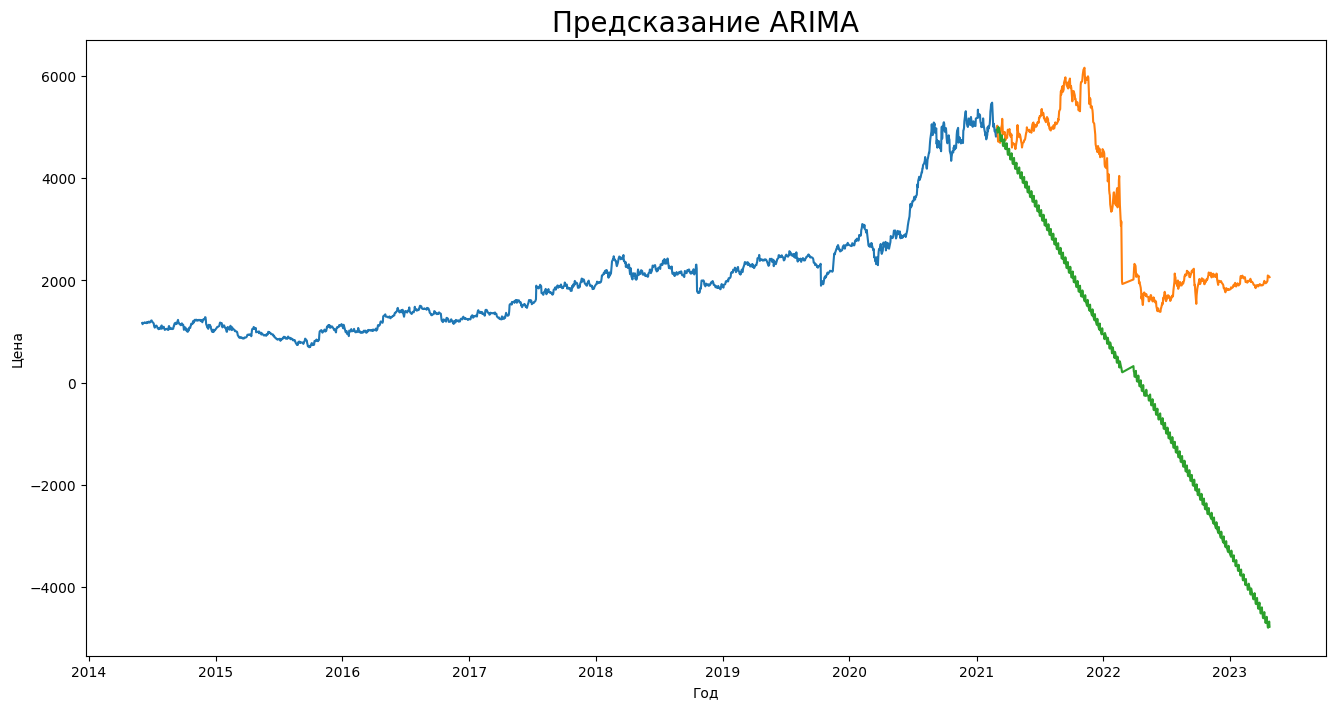

In [44]:
# Задаем размер фигуры.
plt.figure(figsize=(16, 8))

# Построим график.
plt.plot(train)
plt.plot(test)
plt.plot(forecast_aa)
plt.title('Предсказание ARIMA', size=20)
plt.ylabel('Цена')
plt.xlabel('Год');

На графике видно, что модель совершенно не имеет предсказательной способности.

## Пророк - PROPHET

In [45]:
# Сделаем копию.
df_for_pr = df_for_ses.copy()
# Переводим индекс в признак.
df_for_pr = df_for_pr.reset_index()
# Переименовываем столбцы.
df_for_pr.rename(columns={'close': 'y', 'date': 'ds'}, inplace=True)
# Выводим для просмотра.
display(df_for_pr.head())

,ds,y
0,2014-06-04,1170.0
1,2014-06-05,1145.1
2,2014-06-06,1163.0
3,2014-06-09,1172.1
4,2014-06-10,1170.0


In [46]:
# Разделим данные на тренировчную и тестовую выборки.
train = df_for_pr[:1696]
test1 = df_for_pr[1696:]
print('Размеры тренировочной и тестовой выборок:', train.shape, test.shape)

Размеры тренировочной и тестовой выборок: (1696, 2) (526, 1)


In [47]:
# Преобразуем тестовую выборку.
test = test1.set_index('ds')

In [48]:
# Иницианализируем модель класса пророк.
model_pr = Prophet(daily_seasonality = True) 
# Обучаем модель.
model_pr.fit(train) 
# Указываем количество дней для предсказания.
future = model_pr.make_future_dataframe(periods=526) 
# Обучаем модель.
prediction = model_pr.predict(future)
# prediction

DEBUG:cmdstanpy:input tempfile: /tmp/tmpyx4c8hg3/24n_fr4u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyx4c8hg3/0fi7sqvv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65639', 'data', 'file=/tmp/tmpyx4c8hg3/24n_fr4u.json', 'init=/tmp/tmpyx4c8hg3/0fi7sqvv.json', 'output', 'file=/tmp/tmpyx4c8hg3/prophet_modeleg8b3m7h/prophet_model-20230504113349.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:33:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:33:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [49]:
# # Выводим метрику.
# print('MAE: {:.3f}'.format(metrics.mean_absolute_error(test, prediction)))
# print()
# print('RMSE: {:.3f}'.format(metrics.mean_squared_error(test, prediction)))

Метрика стала гораздо хуже предыдущих моделей.

<Figure size 1600x800 with 0 Axes>

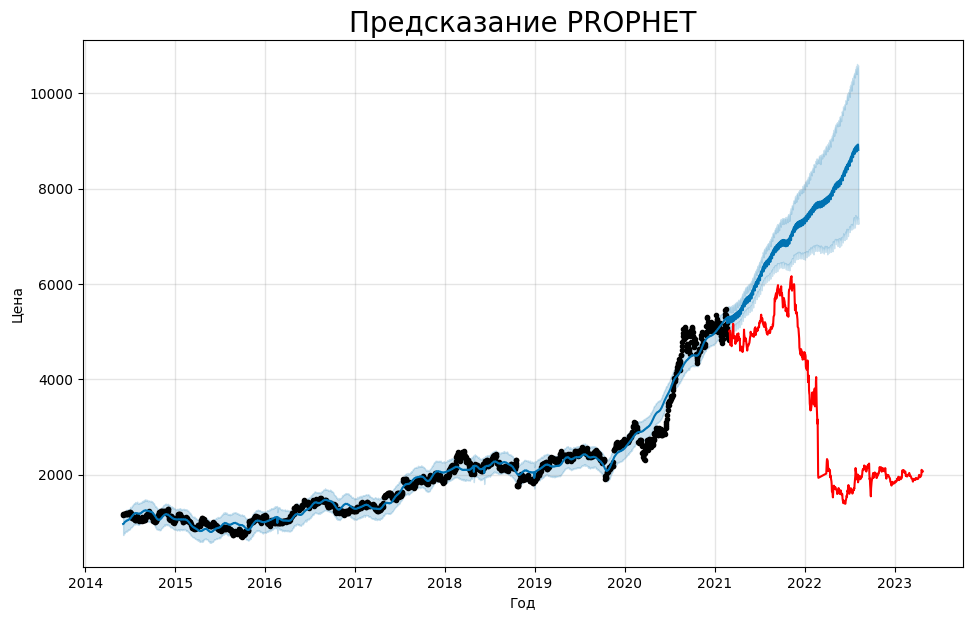

In [50]:
# Задаем размер фигуры.
plt.figure(figsize=(16, 8))

# Построим график
model_pr.plot(prediction)
plt.plot(test, color='red')
plt.title('Предсказание PROPHET', size=20)
plt.xlabel('Год')
plt.ylabel('Цена');

Из графика видно, что модель уловила тренд, но в действительности цены повели себя другим образом.

## Сравнение результатов

In [51]:
# Создадим датафрейм с метриками каждой модели.
data = pd.DataFrame({
    'model' : ['SES', 'LinearRegression', 'LinearRegression_new_features', 'KNeighborsRegressor', 'GradientBoostingRegressor', 'ARIMA'],
    'MAE' : [1815.778, 1866.739, 1162.381, 1341.665, 1351.843, 3292.191]
})

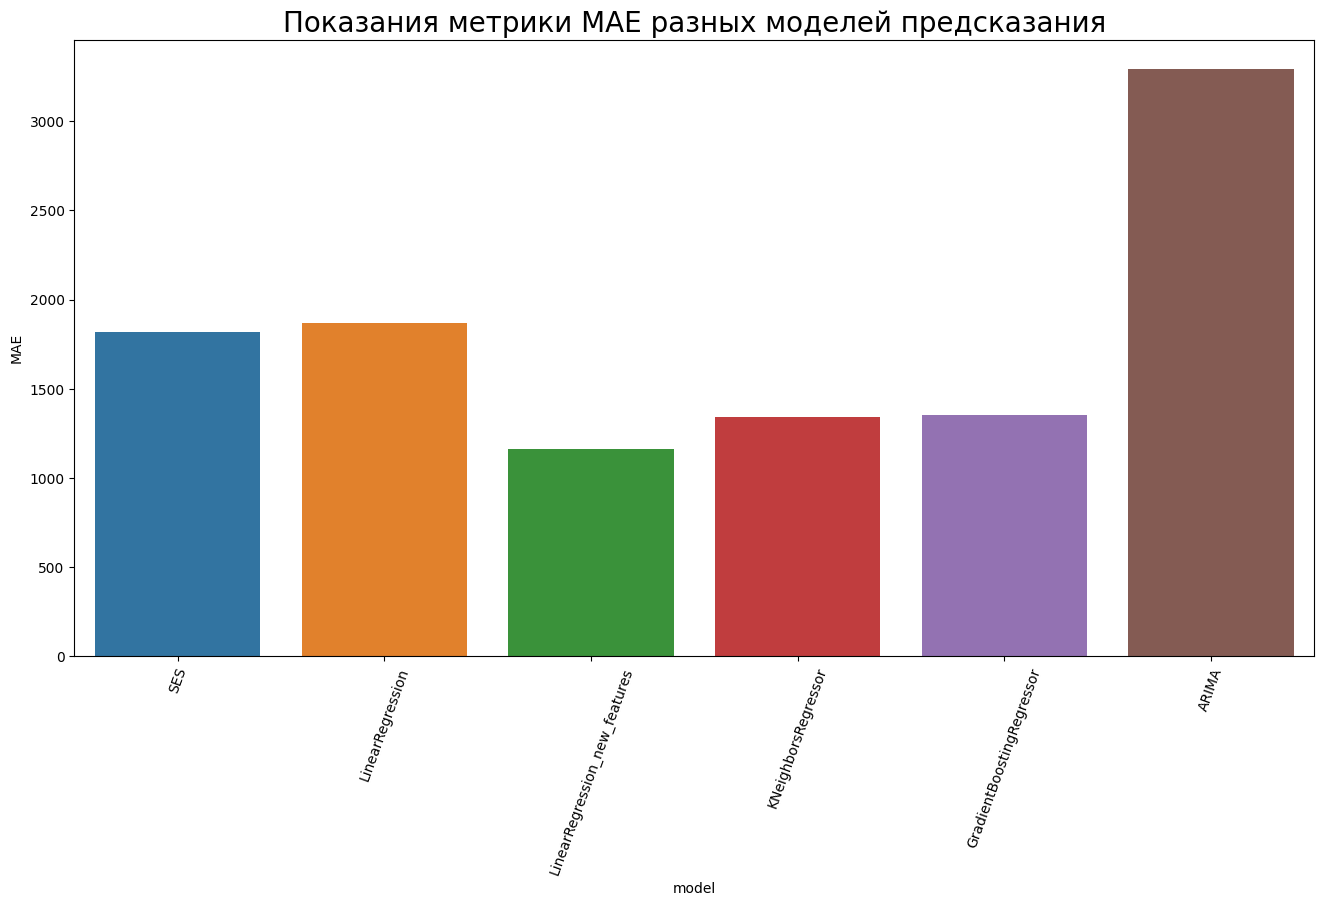

In [52]:
# Задаем размер фигуры.
plt.figure(figsize=(16, 8))

# Построим график.
fig = sns.barplot(
    data=data,
    x='model',
    y='MAE',
    orient='v',
    ci=None
)
fig.tick_params(axis='x', rotation=70);
fig.set_title('Показания метрики MAE разных моделей предсказания', fontsize=20);

Из столбчатой диаграммы видно, что наилучший результат показала модель линейной регрессии с добавлением новых признаков, наихудшей моделью оказалась ARIMA. Из проделанной работы можно сделать вывод, что если мы имеем дело со сложными данными, то необходимо искать другие способы предсказания.